In [8]:
import torch
from torchvision import models
from PIL import Image
import requests
import matplotlib.pyplot as plt

# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load Pre-trained ViT-B/16 (ImageNet-1K weights)
# ViT_B_16_Weights.DEFAULT is equivalent to IMAGENET1K_V1
weights = models.ViT_B_16_Weights.DEFAULT
model = models.vit_b_16(weights=weights).to(device)
model.eval()

# 3. Load the corresponding image processor (transforms)
# This handles the 224x224 resize, center crop, and normalization
preprocess = weights.transforms()

# 4. Get ImageNet class labels for interpretation
# PyTorch provides categories directly from the weights object
class_labels = weights.meta["categories"]

print(f"Model loaded. Using {device} for inference.")

Model loaded. Using cuda for inference.


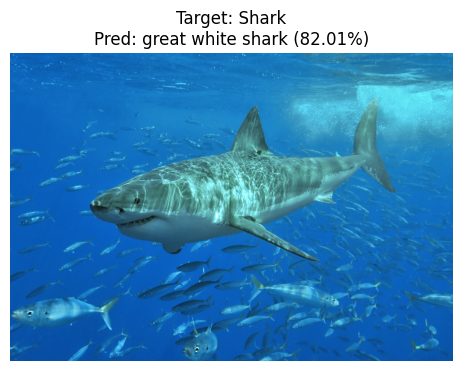

Result for Shark: great white shark (0.8201)
Could not load image Dog: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/b/bd/Golden_Retriever_Dukedog.jpg
Could not load image Car: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/d/d1/Ferrari_458_Italia_--_05-18-2011.jpg


In [9]:
#Task 2.1

import requests
from io import BytesIO

def classify_image(url, target_name):
    # Add headers to avoid 403 Forbidden errors
    headers = {'User-Agent': 'Mozilla/5.0'}
    
    try:
        response = requests.get(url, headers=headers, stream=True)
        response.raise_for_status()
        
        # Open and convert to RGB
        img_raw = Image.open(BytesIO(response.content)).convert('RGB')
        
        # Preprocess
        img_tensor = preprocess(img_raw).unsqueeze(0).to(device)
        
        # Inference
        with torch.no_grad():
            output = model(img_tensor)
        
        # Results
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        top1_prob, top1_id = torch.max(probabilities, 0)
        label = class_labels[top1_id.item()]
        
        # Plot
        plt.figure(figsize=(6, 4))
        plt.imshow(img_raw)
        plt.title(f"Target: {target_name}\nPred: {label} ({top1_prob.item()*100:.2f}%)")
        plt.axis('off')
        plt.show()
        
        print(f"Result for {target_name}: {label} ({top1_prob.item():.4f})")
        
    except Exception as e:
        print(f"Could not load image {target_name}: {e}")

# Try these reliable URLs
# 1. Great White Shark
classify_image("https://upload.wikimedia.org/wikipedia/commons/5/56/White_shark.jpg", "Shark")

# 2. Golden Retriever
classify_image("https://upload.wikimedia.org/wikipedia/commons/b/bd/Golden_Retriever_Dukedog.jpg", "Dog")

# 3. Sports Car
classify_image("https://upload.wikimedia.org/wikipedia/commons/d/d1/Ferrari_458_Italia_--_05-18-2011.jpg", "Car")

In [13]:
#Task 2.2

import torch.nn.functional as F
import cv2
import numpy as np
from io import BytesIO

# 1. Redefine input_tensor
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get("https://upload.wikimedia.org/wikipedia/commons/5/56/White_shark.jpg", headers=headers)
image_raw = Image.open(BytesIO(response.content)).convert('RGB')
input_tensor = preprocess(image_raw).unsqueeze(0).to(device)

# 2. Extract Attention Weights
layer = model.encoder.layers[-1].self_attention
original_forward = layer.forward

def new_forward(*args, **kwargs):
    kwargs['need_weights'] = True
    kwargs['average_attn_weights'] = True # Ensures we get mean across heads
    return original_forward(*args, **kwargs)

layer.forward = new_forward

captured_attn = []
def hook(module, input, output):
    # output is (attn_output, attn_weights)
    captured_attn.append(output[1].detach()) # weights shape: [1, 197, 197]

hook_handle = layer.register_forward_hook(hook)
with torch.no_grad():
    model(input_tensor)
hook_handle.remove()
layer.forward = original_forward

# 3. Handle the Indexing Carefully
last_layer_attn = captured_attn[0] # Shape: [1, 197, 197]

# Remove the batch dimension to get [197, 197]
if last_layer_attn.dim() == 3:
    attn_matrix = last_layer_attn.squeeze(0)
else:
    attn_matrix = last_layer_attn

# Extract [CLS] token (row 0) attention to the image patches (cols 1 to 196)
# result size should be [196]
cls_to_patches = attn_matrix[0, 1:] 

# 4. Reshape and Normalize
attn_map = cls_to_patches.reshape(14, 14).cpu().numpy()
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

print(f"Success! Attention map shape: {attn_map.shape}")

Success! Attention map shape: (14, 14)


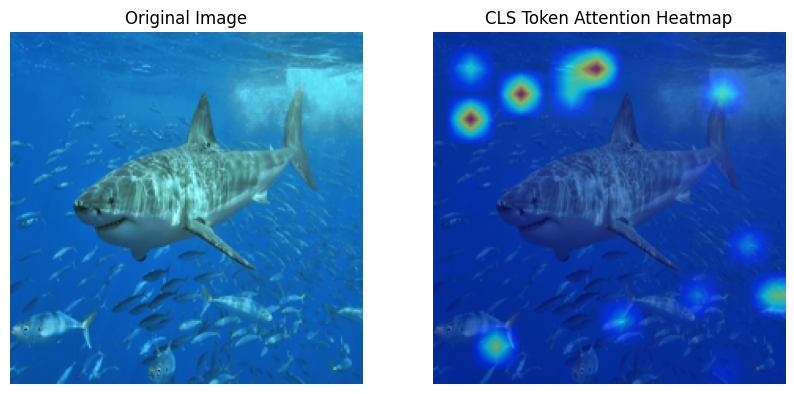

In [ ]:
#Task 2.2 and 2.3

# 1. Resizing and Overlay
attn_resized = cv2.resize(attn_map, (224, 224))
img_vis = image_raw.resize((224, 224))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_vis)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_vis)
# Overlay the attention using a semi-transparent 'jet' colormap
plt.imshow(attn_resized, cmap='jet', alpha=0.5) 
plt.title("CLS Token Attention Heatmap")
plt.axis('off')

plt.show()

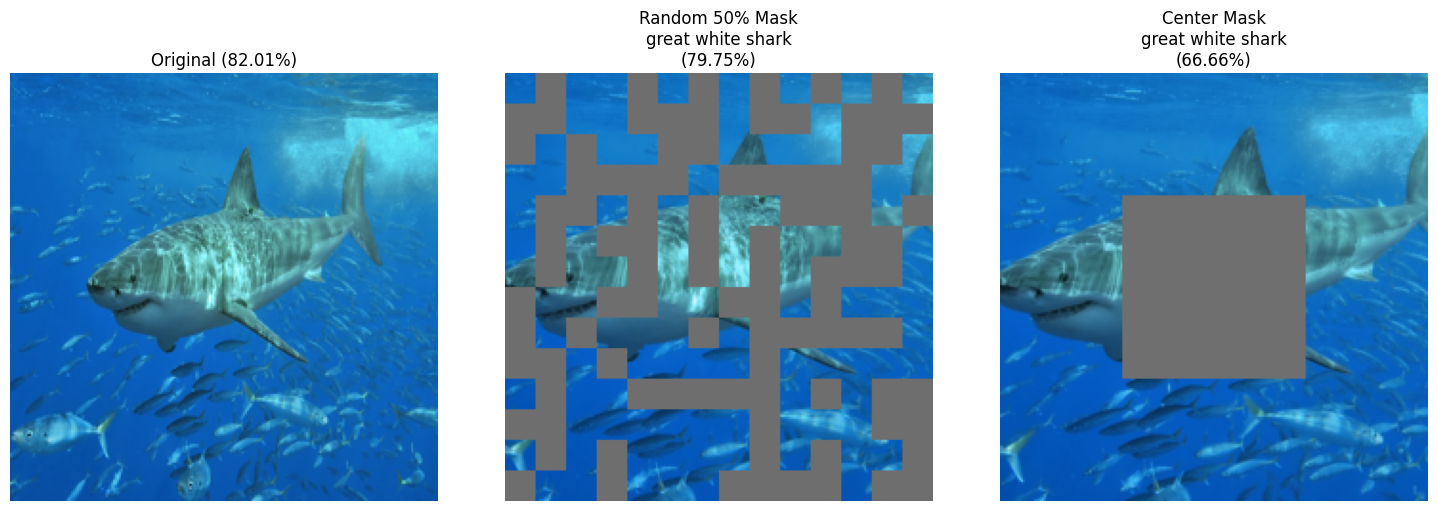

In [16]:
#Task 2.4

def apply_mask(image_tensor, mask_type='random', fraction=0.5):
    """
    Masks patches of a 224x224 image (14x14 grid of 16x16 patches).
    """
    masked_img = image_tensor.clone()
    patch_size = 16
    num_patches_side = 14
    
    if mask_type == 'random':
        # Select random indices to mask
        total_patches = num_patches_side ** 2
        num_to_mask = int(total_patches * fraction)
        indices = np.random.choice(total_patches, num_to_mask, replace=False)
        
        for idx in indices:
            r, c = divmod(idx, num_patches_side)
            masked_img[:, :, r*patch_size:(r+1)*patch_size, c*patch_size:(c+1)*patch_size] = 0
            
    elif mask_type == 'center':
        # Mask a central 6x6 patch area (approx center of the shark)
        # 14 patches total, index 4 to 10 covers the middle 6 patches
        start, end = 4, 10 
        masked_img[:, :, start*patch_size:end*patch_size, start*patch_size:end*patch_size] = 0
        
    return masked_img

# 1. Prepare Masks
img_random_masked = apply_mask(input_tensor, mask_type='random', fraction=0.5)
img_center_masked = apply_mask(input_tensor, mask_type='center')

# 2. Run Inference on Masked Images
with torch.no_grad():
    out_rand = model(img_random_masked)
    prob_rand, id_rand = torch.max(torch.softmax(out_rand[0], 0), 0)
    
    out_center = model(img_center_masked)
    prob_center, id_center = torch.max(torch.softmax(out_center[0], 0), 0)

# 3. Visualization
plt.figure(figsize=(15, 5))

# Original
plt.subplot(1, 3, 1)
plt.imshow(image_raw.resize((224,224)))
plt.title("Original (82.01%)")
plt.axis('off')

# Random Mask
plt.subplot(1, 3, 2)
rand_vis = img_random_masked[0].permute(1,2,0).cpu().numpy()
rand_vis = (rand_vis - rand_vis.min()) / (rand_vis.max() - rand_vis.min())
plt.imshow(rand_vis)
# Using class_labels from the weights meta-data defined in Cell 1
plt.title(f"Random 50% Mask\n{class_labels[id_rand.item()]}\n({prob_rand.item()*100:.2f}%)")
plt.axis('off')

# Center Mask
plt.subplot(1, 3, 3)
center_vis = img_center_masked[0].permute(1,2,0).cpu().numpy()
center_vis = (center_vis - center_vis.min()) / (center_vis.max() - center_vis.min())
plt.imshow(center_vis)
plt.title(f"Center Mask\n{class_labels[id_center.item()]}\n({prob_center.item()*100:.2f}%)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
#Task 2.5

# 1. Extraction function for both pooling methods
def get_pooled_features(image_tensor):
    with torch.no_grad():
        # Get intermediate features (before the final head)
        # For torchvision vit_b_16, we can use the 'encoder' output
        x = model._process_input(image_tensor)
        n = x.shape[0]
        
        # Expand the class token to the full batch
        batch_class_token = model.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        
        # Pass through encoder
        x = model.encoder(x)
        
        # Method A: CLS Token (Index 0)
        cls_token_feat = x[:, 0]
        
        # Method B: Mean of Patch Tokens (Index 1 onwards)
        mean_patch_feat = x[:, 1:].mean(dim=1)
        
        return cls_token_feat, mean_patch_feat

# 2. Get features for the shark image
cls_feat, mean_feat = get_pooled_features(input_tensor)

# 3. Compare via the classification head
# We pass both through the final layer to see which the model 'prefers'
with torch.no_grad():
    # Standard ViT forward uses the CLS token
    out_cls = model.heads(cls_feat)
    prob_cls = torch.softmax(out_cls, dim=1).max().item()
    
    # Alternative: Use the mean of patches
    out_mean = model.heads(mean_feat)
    prob_mean = torch.softmax(out_mean, dim=1).max().item()

print(f"Confidence using [CLS] token: {prob_cls*100:.2f}%")
print(f"Confidence using Mean Patch tokens: {prob_mean*100:.2f}%")

Confidence using [CLS] token: 82.01%
Confidence using Mean Patch tokens: 0.32%
